1: Import thư viện và định nghĩa biến toàn cục

In [20]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Đường dẫn dữ liệu
BASE_PATH = r"D:\file\project\Sign-Language-Classification-v1.0\data\anphabet"
VIETNAMESE_ALPHABET = [
    'a', 'b', 'c', 'd', 'đ', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n',
    'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y'
]


2: Hàm tạo heatmap từ landmarks

In [21]:
def create_heatmap(landmarks, img_size=(224, 224), sigma=5):
    if len(landmarks) % 3 != 0:
        print(f"Warning: Invalid landmark data length {len(landmarks)}. Expected multiple of 3.")
        return np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)

    heatmap = np.zeros(img_size, dtype=np.float32)
    for i in range(0, len(landmarks), 3):
        x, y = landmarks[i], landmarks[i+1]
        if x == 0 and y == 0:
            continue
        x_px = int(x * img_size[1])
        y_px = int(y * img_size[0])
        if 0 <= x_px < img_size[1] and 0 <= y_px < img_size[0]:
            for j in range(-sigma * 3, sigma * 3 + 1):
                for k in range(-sigma * 3, sigma * 3 + 1):
                    if 0 <= y_px + k < img_size[0] and 0 <= x_px + j < img_size[1]:
                        heatmap[y_px + k, x_px + j] += np.exp(-(j**2 + k**2) / (2 * sigma**2))

    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    heatmap = (heatmap * 255).astype(np.uint8)
    return np.stack([heatmap] * 3, axis=2)


3: Hàm load dữ liệu landmarks và chuyển thành heatmap

In [22]:
def load_landmarks_data():
    data = []
    labels = []
    for label_idx, letter in enumerate(VIETNAMESE_ALPHABET):
        folder_path = os.path.join(BASE_PATH, letter)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist.")
            continue
        for i in range(1, 51):
            file_path = os.path.join(folder_path, f"{i}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                landmarks = df.values.flatten()
                heatmap = create_heatmap(landmarks)
                data.append(heatmap)
                labels.append(label_idx)
    if not data:
        raise ValueError("No data loaded. Please check the data directory and CSV files.")
    return np.array(data), np.array(labels)


4: Chuẩn bị dữ liệu và chia tập

In [23]:
# Load dữ liệu
data, labels = load_landmarks_data()

# One-hot encode
labels = np.eye(23)[labels]

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Chuẩn hóa input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)


5: Data Augmentation và xây dựng mô hình

In [24]:
# Augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=False
)

# Base model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(23, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze toàn bộ ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


6: Huấn luyện mô hình lần 1 (ResNet frozen)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


d:\anaconda3\envs\mnist_project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 940ms/step - accuracy: 0.1915 - loss: 2.9687 - val_accuracy: 0.4261 - val_loss: 1.8840
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 892ms/step - accuracy: 0.6061 - loss: 1.5509 - val_accuracy: 0.7913 - val_loss: 1.0609
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 877ms/step - accuracy: 0.7980 - loss: 0.9664 - val_accuracy: 0.8348 - val_loss: 0.7587
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 894ms/step - accuracy: 0.8988 - loss: 0.5990 - val_accuracy: 0.9304 - val_loss: 0.4733
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 873ms/step - accuracy: 0.9296 - loss: 0.4269 - val_accuracy: 0.9478 - val_loss: 0.3970
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 880ms/step - accuracy: 0.9454 - loss: 0.3327 - val_accuracy: 0.9391 - val_loss: 0.3565
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 878ms/step - accuracy: 0.9548 - loss: 0.2877 - val_accuracy: 0.9391 - val_loss: 0.3041
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 879ms/step - accuracy: 0.9701 - loss: 0.2244 - val_accu

7: Fine-tune – Mở khóa 10 tầng cuối ResNet50

In [26]:
# Unfreeze 10 tầng cuối cùng
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train thêm
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 999ms/step - accuracy: 0.9458 - loss: 0.1922 - val_accuracy: 0.9652 - val_loss: 0.1467
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 950ms/step - accuracy: 0.9885 - loss: 0.0268 - val_accuracy: 0.9652 - val_loss: 0.1357
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 948ms/step - accuracy: 0.9923 - loss: 0.0239 - val_accuracy: 0.9739 - val_loss: 0.0893
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 943ms/step - accuracy: 0.9958 - loss: 0.0159 - val_accuracy: 0.9478 - val_loss: 0.1655
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 953ms/step - accuracy: 0.9958 - loss: 0.0155 - val_accuracy: 0.9826 - val_loss: 0.0770
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 952ms/step - accuracy: 0.9956 - loss: 0.0131 - val_accuracy: 0.9826 - val_loss: 0.0648
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 941ms/step - accuracy: 0.9983 - loss: 0.0089 - val_accuracy: 0.9739 - val_loss: 0.0863
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 944ms/step - accuracy: 0.9974 - loss: 0.0077 - val_accu

8: Đánh giá và lưu mô hình

In [27]:
# Lưu mô hình
model.save('vsl_cnn_pose_keras.h5')

# Đánh giá
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"🎯 Test Accuracy: {test_acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step - accuracy: 0.9705 - loss: 0.1425
🎯 Test Accuracy: 96.52%


9: Vẽ biểu đồ huấn luyện

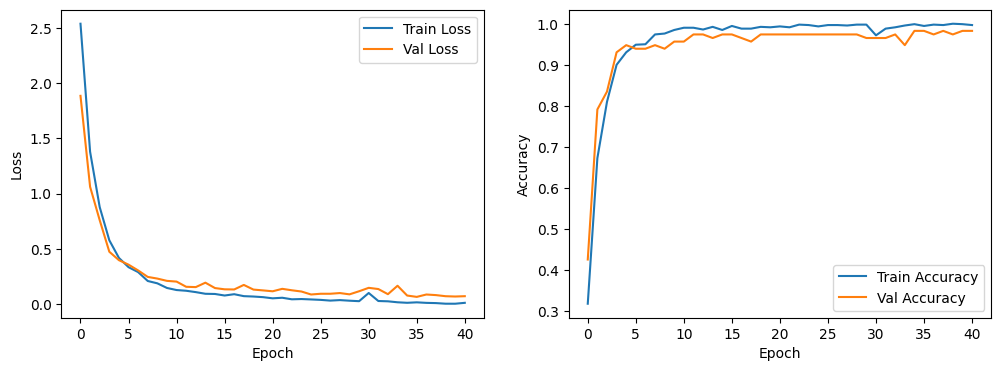

In [28]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('training_plot_keras.png')
plt.show()
